# 라이브러리

In [ ]:
from collections import namedtuple                                  #표준 라이브러리 모듈 
import warnings
warnings.filterwarnings(action='ignore')
import urllib
from urllib import parse
from urllib.request import urlopen , Request
from urllib.parse import urlencode, unquote, quote_plus
import json
from datetime import timedelta
import math
import datetime as dt
import time

import numpy as np                                                  #서드 파티 모듈
import sympy as sp
from numpy import array as vector
import matplotlib as plt
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from IPython.display import Image
#import pylint
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
from pandas import Series, DataFrame
import lxml
from datetime import datetime,timedelta
import xmltodict

- 파이썬 표준 라이브러리  
[파이썬문서](https://docs.python.org/ko/3/library/index.html)  
<br/>

- warnings   
[티스토리](https://rfriend.tistory.com/346)
<br/>

# Contents

## - SIR Model for Euler Method
## - SIR Model for Euler Method and Scipy Library (drop-in replacemnet)
## - Numerical Scheme for Scipy with variable initial value
## - Numerical Scheme for Euler Method - Linear IVP model
## - Numerical Scheme for Second-order nonLinear model
## - Visualization Using Public COVID19 data API

---

# 1. SIR Model for Euler Method

---

# Euler Method

- 수치해법을 통해서 미분방정식을 푸는 방법
- 테일러 급수에서 유도된 방법으로, 비교적 오차가 크게 남  
- __두 곡선 사이의 오차는 step size의 크기를 작게하고, 범위를 유한으로 했을 때 줄일 수 있다.__

![오일러 방법](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Euler_method.png/450px-Euler_method.png)

--- 

![식](https://wikimedia.org/api/rest_v1/media/math/render/svg/e227fe9c3d3c0d7b35029b94652748aadd95037a)

![간격](https://wikimedia.org/api/rest_v1/media/math/render/svg/ab911fe932df757154a657563c9a777280c36cbd)

![구간의 크기](https://wikimedia.org/api/rest_v1/media/math/render/svg/652e8d6d7ea3dbc029e073ba79cc11bbb4bf919c)

![식2](https://wikimedia.org/api/rest_v1/media/math/render/svg/09b8e63a9bee073d85e785df898888123de68d2e) 

![h](https://wikimedia.org/api/rest_v1/media/math/render/svg/40c2ea6d83cd3fd870a83d603c4d5626f49357e3)

![변환식](https://wikimedia.org/api/rest_v1/media/math/render/svg/714fc29c1fdac8792ae3b295e0793d0ea06f0d63)

![1번식](https://wikimedia.org/api/rest_v1/media/math/render/svg/b0180145cb212d4c6033244c85a22bc7c86e9178)

![w](https://wikimedia.org/api/rest_v1/media/math/render/svg/ec64c251a3a9eb19dc98752a749c913c0b35d401)

---
 
- 참고  
[위키피디아](https://ko.wikipedia.org/wiki/%EC%98%A4%EC%9D%BC%EB%9F%AC_%EB%B0%A9%EB%B2%95)

---

# SIR Model

- 전염병의 확산을 설명할 때, 수학적인 모델링을 통한 접근 방법
- 잠복기가 없고, 완치 된 후 면역이 생기는 전염병 가정

![변수](https://static.wixstatic.com/media/a27d24_901cd866579146558c29031e631e3e49~mv2.png/v1/fill/w_630,h_387,al_c,q_95/a27d24_901cd866579146558c29031e631e3e49~mv2.webp)

---

![모델](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSsRkG82N1PmjKm77cKZ6_y-Y1BKBgA1Ul69Q&usqp=CAU)

---

- Gamma, Beta    
[각 나라의 지수](https://herald-lab.tistory.com/65)  
<br/>
- SIR 모델      
[사이트](https://www.ksakosmos.com/post/%EB%AC%BC%EB%A6%AC%ED%95%99%EC%9E%90-sir-%EB%AA%A8%EB%8D%B8%EB%A1%9C-%EC%A0%84%EC%97%BC%EB%B3%91%EC%9D%84-%EC%98%88%EC%B8%A1%ED%95%98%EB%8B%A4)    
[Exact Sol](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7445013/)  
<br/>
- 확진자 수    
[실시간 확진자 수(Gamma 기준)](https://coronaboard.kr/)
<br/>


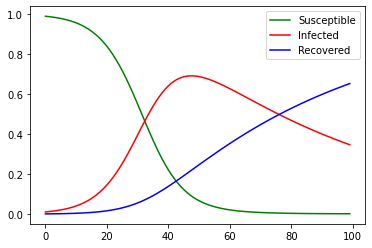

In [ ]:
def sir_euler(days,time_step):
    S = []
    I = []
    R = []
    S.append(0.99)
    I.append(0.01)
    R.append(1 - S[0] - I[0])
    beta = 2.1
    gamma = 0.2
    for i in range(days-1):
        S.append(S[i] + time_step * (-beta * S[i] * I[i]))
        I.append(I[i] + time_step * (beta * S[i] * I[i] - gamma * I[i]))
        R.append(R[i] + time_step * (gamma * I[i]))
    plt.plot(S, color="green")
    plt.plot(I, color="red")
    plt.plot(R, color="blue")
    label = ["Susceptible", "Infected", "Recovered"]
    plt.legend(label)
    
sir_euler(100, 0.08)

---

# 2. SIR Model for Euler Method and Scipy Library (drop-in replacemnet)

---
- Drop in replacement  
[위키피디아](https://en.wikipedia.org/wiki/Drop-in_replacement)  

### Euler Solver , SIR 모델 , Plot 함수  정의

In [ ]:
EulerSol = namedtuple("EulerSol", ["t", "y"])
def euler_solver(f, t_span, x0, h=0.5):                  #np.transpose 안하고 t도 리스트안에 리스트
    t_start, t_final = t_span
    t = t_start
    x = x0
    result_t = [t]
    result_x = [x]
    for i in range(1, round((t_final - t_start) / h)):
        t = t_start + i * h
        x = x + h * f(t, x)
        result_t.append(t)
        result_x.append(x)
    return EulerSol(result_t, vector(result_x).T)

def sir(beta,gamma):
    def f(t,x):
        S , I , R =x
        return vector([ (-beta * S * I) , (beta * S * I - gamma * I),  (gamma * I) ])
    return f

def plot_sir(sol, title="SIR Model", ax=None):         
    if ax is None:
        fig, ax = plt.subplots()
    # ".-" linespec은 t_eval이나 h 확인을 위해
    ax.plot(sol.t, sol.y.T, ".-", label=["Susceptible", "Infected", "Recovered"])
    ax.set(
        xlabel="Time",
        ylabel="Population (normalized)",
        title=title,
    )
    ax.legend()
    ax.grid()                                 #격자
    return ax

class SirModel:                              #클래스 정의
    def __init__(self, beta, gamma):         # Java의 constructor 개념
        self.beta = beta
        self.gamma = gamma

    def __call__(self, t, x):
        S, I, R = x
        return vector(
            [-self.beta * S * I, self.beta * S * I - self.gamma * I, self.gamma * I]
        )

### 매개변수 정의

In [ ]:
beta = 2.1
gamma = 0.2

t_span = [0, 8]
sir_init = [0.99, 0.01, 0.0]

t_eval = np.linspace(*t_span)           #[0,8] 은 input으로 받아지지않음, (0,8) 이어야함
smaller_h = 0.2

### Euler Solver 와 Scipy 를 이용하여 푼 SIR-IVP 해의 plot

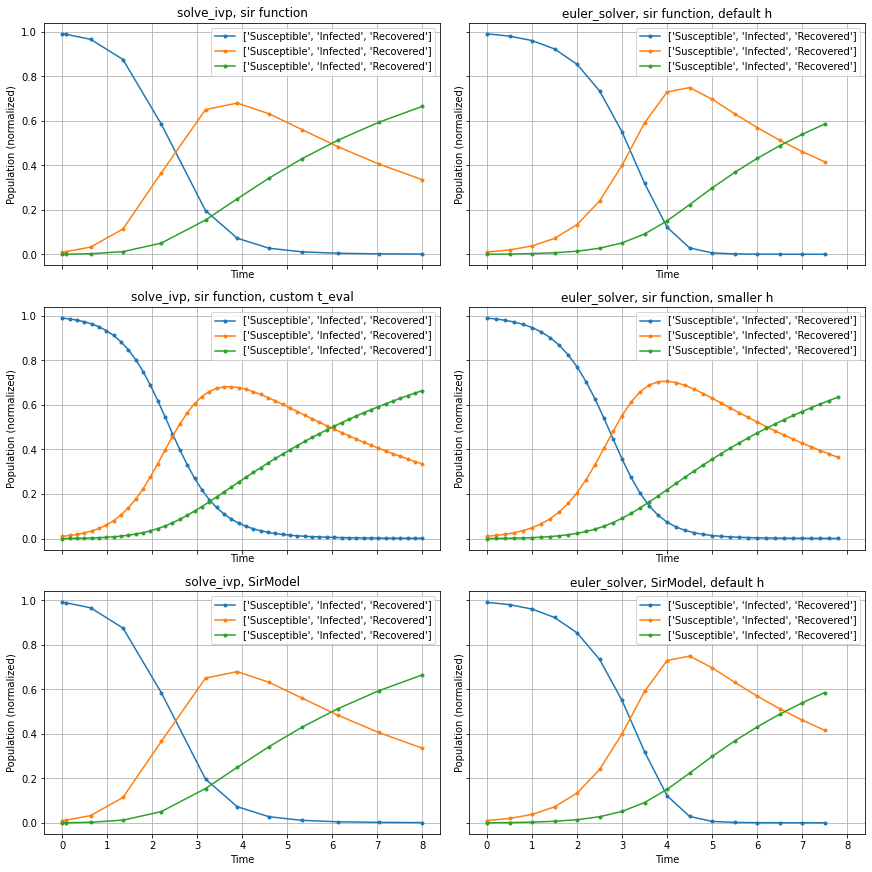

In [ ]:
# 시그니처를 똑같이 맞췄기 때문에 반복문으로 할 수도 있음
fig, axes = plt.subplots(
    3, 2, figsize=(12, 12), constrained_layout=True, sharex=True, sharey=True
)

specs = [
    {
        "title": "solve_ivp, sir function",
        "model": sir(beta, gamma),
        "solver": solve_ivp,
        "options": {},
    },
    {
        "title": "euler_solver, sir function, default h",
        "model": sir(beta, gamma),
        "solver": euler_solver,
        "options": {},
    },
    {
        "title": "solve_ivp, sir function, custom t_eval",
        "model": sir(beta, gamma),
        "solver": solve_ivp,
        "options": {"t_eval": t_eval},
    },
    {
        "title": "euler_solver, sir function, smaller h",
        "model": sir(beta, gamma),
        "solver": euler_solver,
        "options": {"h": smaller_h},
    },
    {
        "title": "solve_ivp, SirModel",
        "model": SirModel(beta, gamma),
        "solver": solve_ivp,
        "options": {},
    },
    {
        "title": "euler_solver, SirModel, default h",
        "model": SirModel(beta, gamma),
        "solver": euler_solver,
        "options": {},
    },
]

for spec, ax in zip(specs, axes.flat):
    sol = spec["solver"](spec["model"], t_span, sir_init, **spec["options"])           #keyword argument
    plot_sir(sol, spec["title"], ax=ax)

- Scipy    
[Adaptive Time step](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)
<br/>

---

# 3. Numerical Scheme for Scipy with variable initial value

---

## 초기값(IVP)문제 : 

- 미분방정식의 분야에서, 초기상태라는 주어진 한 점에서 알 수 없는 함수의 값이 주어진 문제
- 초기 조건이 주어졌을때, 미분방정식의 시스템에 시간에 따라 변화함.
---
## $$y' = y $$ 
## $$y(0) = -0.0000001 \; ,0 \; , \; 0.0000001 $$ 

---
-참고  
[위키피디아](https://ko.wikipedia.org/wiki/%EC%B4%88%EA%B8%B0%EA%B0%92_%EB%AC%B8%EC%A0%9C)

In [ ]:
t_span=[0,100]
init_neg_divergence=[-0.0000001]
init_stable=[0]
init_pos_divergence=[0.0000001]

def dydt(t, y):           
    return y

def plot_variable(sol, title="Numerical Scheme Scipy", ax=None):         
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(sol.t, sol.y.T, ".-")
    ax.set(
        xlabel="Time",
        ylabel="Solution",
        title=title,
    )
    label=["solution"]
    ax.legend(label)
    ax.grid()                                 #격자
    return ax

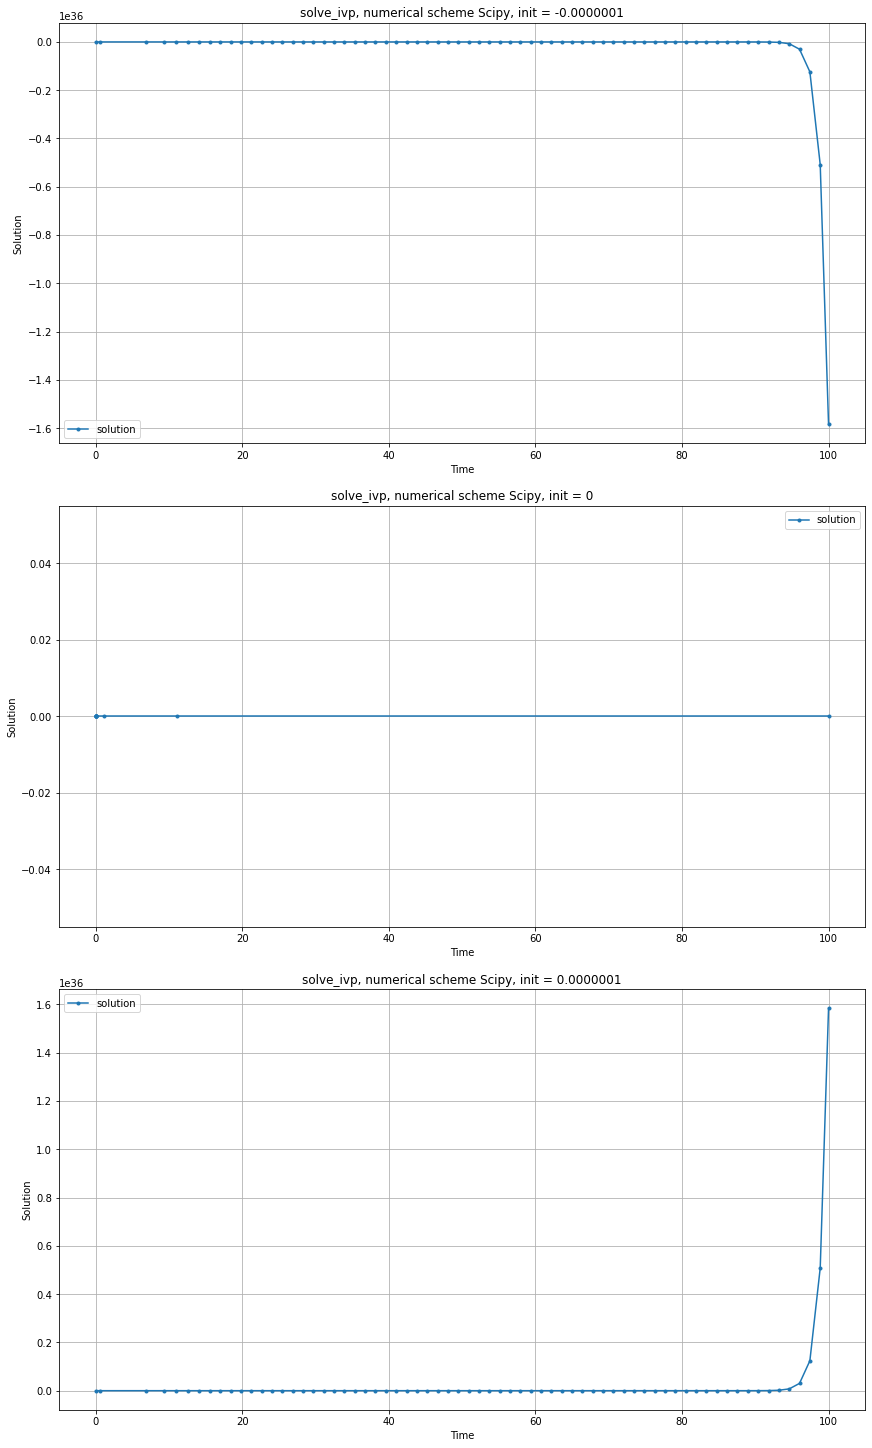

In [ ]:
fig, axes = plt.subplots(
    3, 1, figsize=(12, 20), constrained_layout=True, sharex=False, sharey=False                
)
specs = [
    {
        "title": "solve_ivp, numerical scheme Scipy, init = -0.0000001",
        "model": dydt,
        "solver": solve_ivp,
        "options": init_neg_divergence,
    },
    {
        "title": "solve_ivp, numerical scheme Scipy, init = 0",
        "model": dydt,
        "solver": solve_ivp,
        "options": init_stable,
    },
    {
        "title": "solve_ivp, numerical scheme Scipy, init = 0.0000001",
        "model": dydt,
        "solver": solve_ivp,
        "options": init_pos_divergence,
    },
]
for spec, ax in zip(specs, axes.flat):
    sol = spec["solver"](spec["model"], t_span, spec["options"])           #keyword argument
    plot_variable(sol, spec["title"], ax=ax)

---

# 4. Numerical Scheme for Euler Method - Linear IVP model

---
<img src="images/steady5.JPG"> 

---
## 예시: λ = 0 , -3  corresponding with X1 = [ 2 , 1] , X2 = [ -1 , 1]
## Critical point = ( 0 , 0 ) , ( 2 , 1 )
## $$ \frac{du_1}{dt} = -u_1 + 2u_2 $$
## $$ \frac{du_2}{dt} =  u_1 - 2u_2 $$
![Solution](steady6.jpg)
![stability](steady1.jpg)

--- 
- steady states stability      
[티스토리](https://twlab.tistory.com/50)      
[고유값 별로 나눈 case](https://eng.libretexts.org/Bookshelves/Industrial_and_Systems_Engineering/Book%3A_Chemical_Process_Dynamics_and_Controls_(Woolf)/10%3A_Dynamical_Systems_Analysis/10.04%3A_Using_eigenvalues_and_eigenvectors_to_find_stability_and_solve_ODEs)  
<br/>
---

---
# <center> <Effect of step size on Euler's method> </center>

## Supp that λ ≤ 0.
## Then,
## $$ f(t,y) = λy(t) $$
## $$ y_{n+1} = y_n + hf(t_n,y_n) $$
## $$         = y_n + h\lambda y_n $$
## $$         = (1+\lambda h)y_n $$
## By induction,
## $$ y_n     = (1+\lambda h)^ny_n $$
## $$|1+\lambda h| <1 $$
## $$ -2 < \lambda h < 0  ⇐⇒  h < \frac{-2}{\lambda} $$
    
---
- Euler Method Step Size    
[pdf](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)    

In [ ]:
EulerSol = namedtuple("EulerSol", ["t", "y"])
def euler_solver(f, t_span, x0, h):                 
    t_start, t_final = t_span
    t = t_start
    x = x0
    result_t = [t]
    result_x = [x]
    for i in range(1, round((t_final - t_start) / h)):
        t = t_start + i * h
        x = x + h * f(t, x)
        result_t.append(t)
        result_x.append(x)
    return EulerSol(result_t, vector(result_x).T)

def numerical_scheme():
    def f(t,x):
        u1 , u2 = x
        return vector([(-u1 + 2 * u2) , (u1 - 2 * u2)])
    return f

def plot_numerical(sol, title="Numerical Scheme Model", ax=None):         
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(sol.t, sol.y.T, ".-")
    ax.set(
        xlabel="Time",
        ylabel="Solution",
        title=title,
    )
    label=["u1","u2"]
    ax.legend(label)
    ax.grid()                                 #격자
    return ax

In [ ]:
t_span=[0,100]
numerical_init=[1,0]
default_h=1
critical_value=2/3
epsilon=0.05

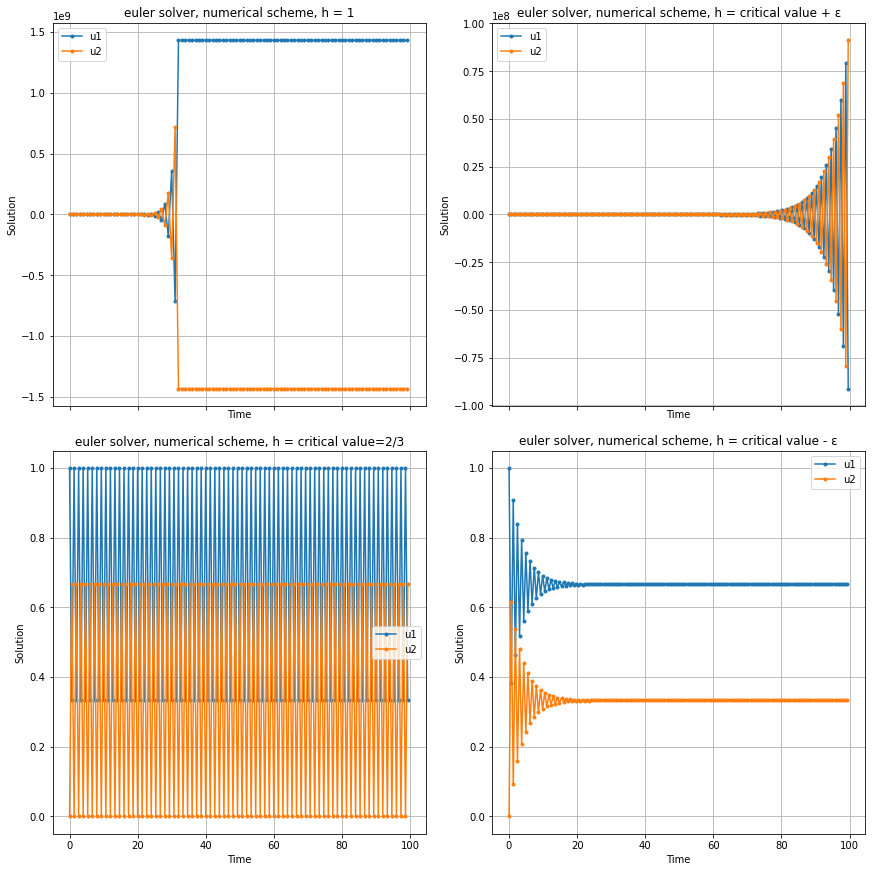

In [ ]:
fig, axes = plt.subplots(
    2, 2, figsize=(12, 12), constrained_layout=True, sharex=True, sharey=False                #sharey = F 해야함 (범위 차이 큼)
)
specs = [
    {
        "title": "euler solver, numerical scheme, h = 1",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "options": {"h": default_h},
    },
    {
        "title": "euler solver, numerical scheme, h = critical value + ε",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "options": {"h": critical_value+epsilon},
    },
    {
        "title": "euler solver, numerical scheme, h = critical value=2/3",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "options": {"h": critical_value},
    },
    {
        "title": "euler solver, numerical scheme, h = critical value - ε",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "options": {"h": critical_value-epsilon},
    },
]
for spec, ax in zip(specs, axes.flat):
    sol = spec["solver"](spec["model"], t_span, numerical_init, **spec["options"])           #keyword argument
    plot_numerical(sol, spec["title"], ax=ax)

## Critical point : (0 , 0 ) => c1=0 , c2=0 
## $$ u(t) = [ 0 , 0] $$
## Critical point : (2 , 1 ) => c1=1 , c2=0
## $$ u(t) = [ 2 , 1] $$

In [ ]:
t_span=[0,100]
numerical_init1=[0,0]
numerical_init2=[2,1]
critical_value=2/3
epsilon=0.05

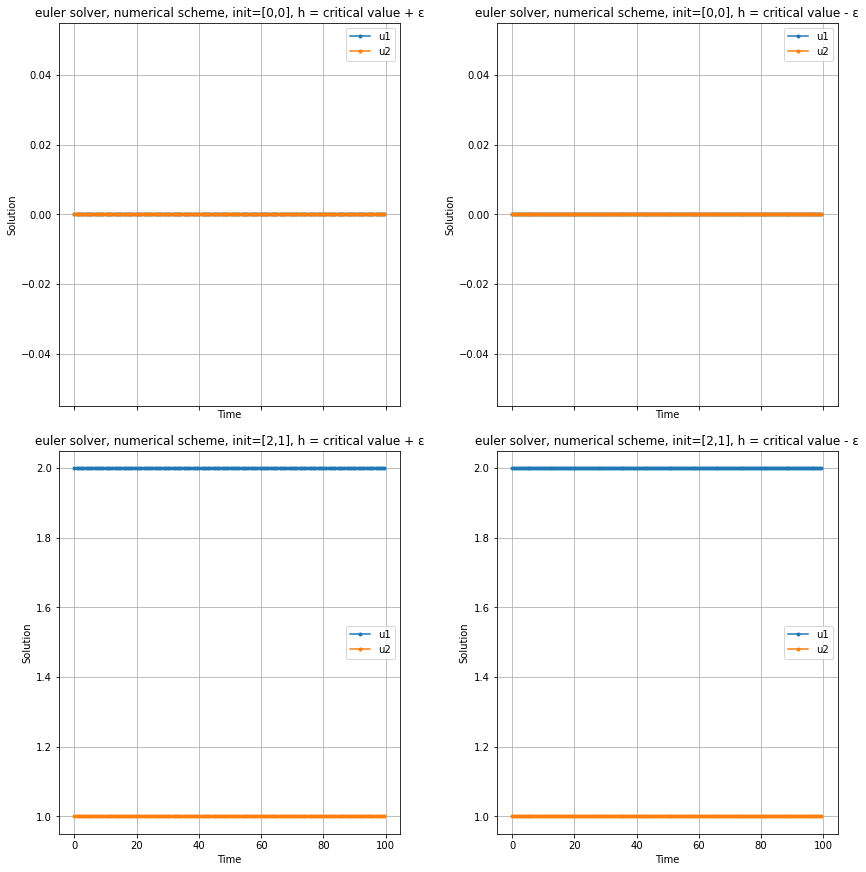

In [ ]:
fig, axes = plt.subplots(
    2, 2, figsize=(12, 12), constrained_layout=True, sharex=True, sharey=False                #sharey = F 해야함 (범위 차이 큼)
)
specs = [
    {
        "title": "euler solver, numerical scheme, init=[0,0], h = critical value + ε",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "init": {"x0" : numerical_init1},
        "options": {"h": critical_value+epsilon},
    },
    {
        "title": "euler solver, numerical scheme, init=[0,0], h = critical value - ε",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "init": {"x0" : numerical_init1},
        "options": {"h": critical_value-epsilon},
    },
    {
        "title": "euler solver, numerical scheme, init=[2,1], h = critical value + ε",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "init": {"x0" : numerical_init2},
        "options": {"h": critical_value+epsilon},
    },
    {
        "title": "euler solver, numerical scheme, init=[2,1], h = critical value - ε",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "init": {"x0" : numerical_init2},
        "options": {"h": critical_value-epsilon},
    },
]
for spec, ax in zip(specs, axes.flat):
    sol = spec["solver"](spec["model"], t_span, **spec["init"], **spec["options"])           #keyword argument
    plot_numerical(sol, spec["title"], ax=ax)

In [ ]:
t_span=[0,100]
numerical_init3=[0.1,0.1]
numerical_init4=[2.1,1.1]
critical_value=2/3
epsilon=0.05

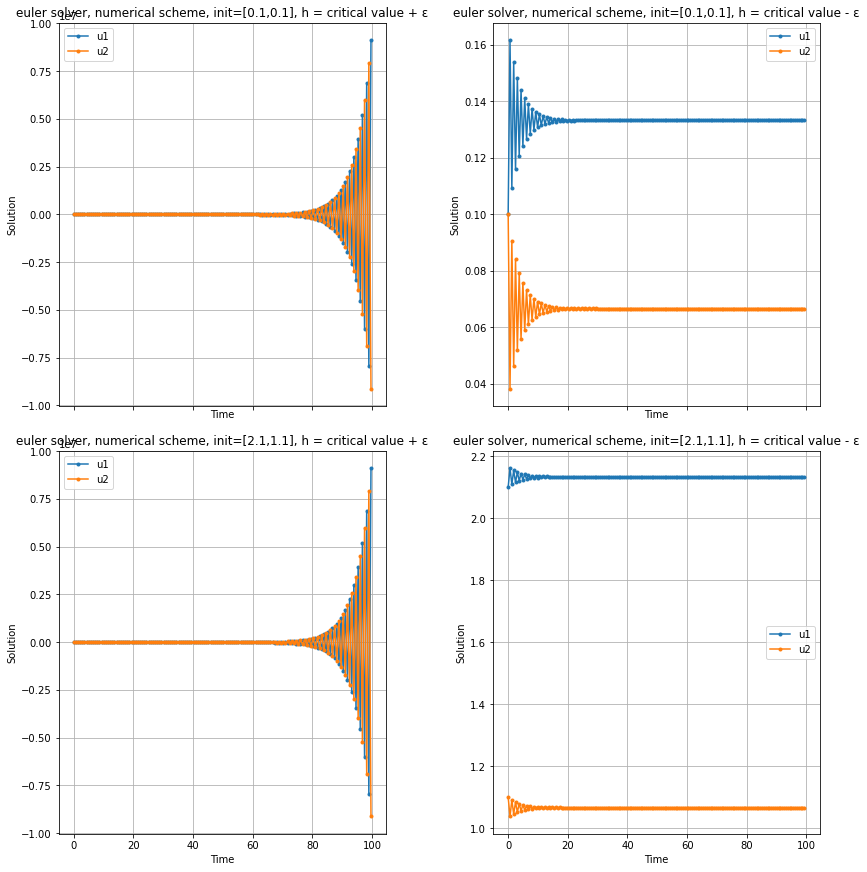

In [ ]:
fig, axes = plt.subplots(
    2, 2, figsize=(12, 12), constrained_layout=True, sharex=True, sharey=False                #sharey = F 해야함 (범위 차이 큼)
)
specs = [
    {
        "title": "euler solver, numerical scheme, init=[0.1,0.1], h = critical value + ε",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "init": {"x0" : numerical_init3},
        "options": {"h": critical_value+epsilon},
    },
    {
        "title": "euler solver, numerical scheme, init=[0.1,0.1], h = critical value - ε",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "init": {"x0" : numerical_init3},
        "options": {"h": critical_value-epsilon},
    },
    {
        "title": "euler solver, numerical scheme, init=[2.1,1.1], h = critical value + ε",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "init": {"x0" : numerical_init4},
        "options": {"h": critical_value+epsilon},
    },
    {
        "title": "euler solver, numerical scheme, init=[2.1,1.1], h = critical value - ε",
        "model": numerical_scheme(),
        "solver": euler_solver,
        "init": {"x0" : numerical_init4},
        "options": {"h": critical_value-epsilon},
    },
]
for spec, ax in zip(specs, axes.flat):
    sol = spec["solver"](spec["model"], t_span, **spec["init"], **spec["options"])           #keyword argument
    plot_numerical(sol, spec["title"], ax=ax)

Text(0.5, 1.0, 'Quiver plot')

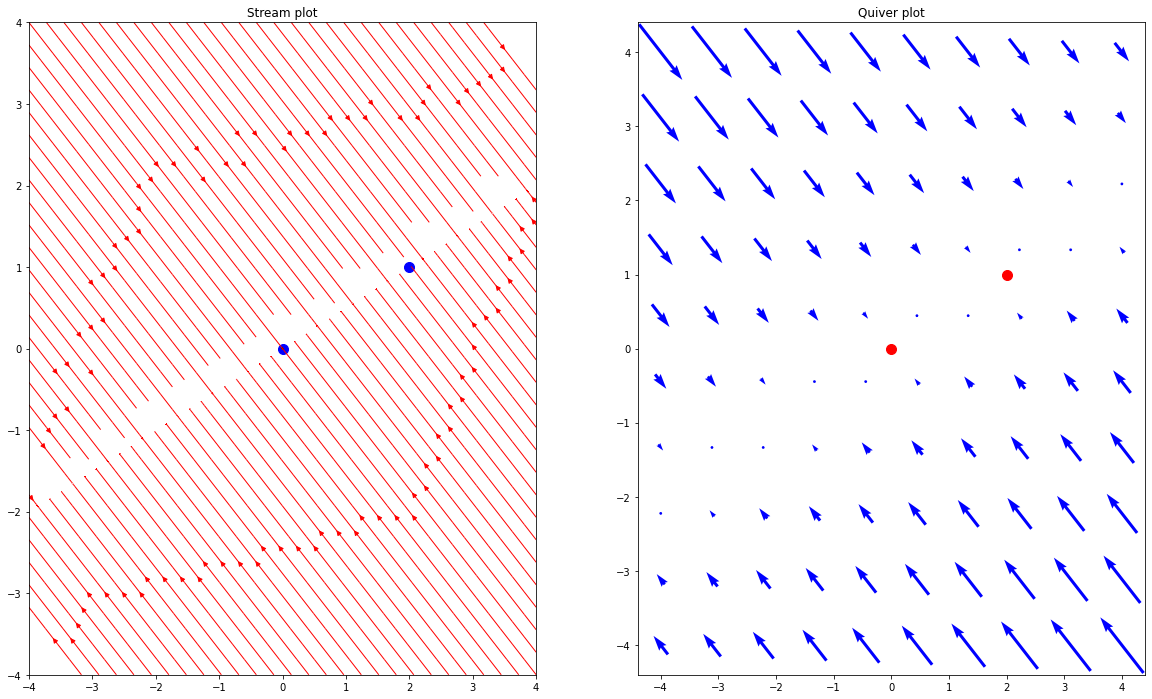

In [ ]:
w = 4
u2, u1 = np.mgrid[-w:w:100j, -w:w:100j]
aa=[0,2]
bb=[0,1]

fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(nrows=1, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.streamplot(u1,u2,-u1+2*u2,u1-2*u2,color='red',linewidth=1)
ax0.scatter(aa,bb,color='blue',s=100)
ax0.set_title('Stream plot')

u2, u1 = np.mgrid[-w:w:10j, -w:w:10j]
ax1 = fig.add_subplot(gs[0, 1])
ax1.quiver(u1,u2,-u1+2*u2,u1-2*u2,color='blue',angles='xy',pivot='middle')
ax1.scatter(aa,bb,color='red',s=100)
ax1.set_title('Quiver plot')

- stream plot      
[옵션별 plot](https://matplotlib.org/stable/gallery/images_contours_and_fields/plot_streamplot.html)    
<br/>

- quiver plot      
[티스토리](https://amornatura.tistory.com/69)    
<br/>

- np.mgrid      
[공식문서](https://numpy.org/doc/stable/reference/generated/numpy.mgrid.html)    
<br/>

---

# 5. Numerical Scheme for Second-order nonLinear model

---


## $x' = 8x-2x^2-2xy \quad --> \quad x(8-2x-2y)=0 \quad $
## $y' = xy-y \quad \quad \quad \quad \; --> \quad y(x-1)=0$
## $$ \{x=0 \quad or \quad y=4-x\} $$
## $$ \{y=0 \quad or \quad x=1 \; \} $$
## $$ ∴ Fixed point \; = \; (0,0), (4,0), (1,3) $$ 
## $$ DF = \left[\begin{array}{rrr} 
8-4x-2y&-2x\\
y&x-1\\
\end{array}\right]$$ 

- 비선형 ODE      
[블로그](https://m.blog.naver.com/sw4r/221826620994)    
<br/>

- Linearization and Stability Analysis of Nonlinear Problems  
[pdf](https://scholar.rose-hulman.edu/cgi/viewcontent.cgi?article=1033&context=rhumj)    
<br/>  

In [ ]:
def find_ev(x,y):
    jacobian=np.array([[8-4*x-2*y,-2*x],[y,x-1]])
    eigen_value,eigen_vector=np.linalg.eig(jacobian)
    print("eigen value :\n", eigen_value)
    print("eigen vector :\n", eigen_vector)
    print("\n")

fixed_point=([0,0],[4,0],[1,3])
for x,y in fixed_point:
    find_ev(x,y)

eigen value :
 [ 8. -1.]
eigen vector :
 [[1. 0.]
 [0. 1.]]


eigen value :
 [-8.  3.]
eigen vector :
 [[ 1.         -0.5881717 ]
 [ 0.          0.80873608]]


eigen value :
 [-1.+2.23606798j -1.-2.23606798j]
eigen vector :
 [[-0.25819889+0.57735027j -0.25819889-0.57735027j]
 [ 0.77459667+0.j          0.77459667-0.j        ]]




---

## $ 고유값:  [ 8 , -1 ]  고유벡터 : [1 , 0] , [0 , 1] $
## $ 고유값:  [ -8 , 3 ]  고유벡터 : [1 , 0] , [-0.5881717 , 0.80873608] $
## $ 고유값:  [ -1+$$\sqrt{5}$$i , -1-$$\sqrt{5}$$i ] $ 
## $ 고유벡터 : [-0.25819889+0.57735027j , 0.77459667] , [-0.25819889-0.57735027j , 0.77459667] $

---

![condition](steady3.jpg)
![condition2](steady4.jpg)

Text(0.5, 1.0, 'Quiver plot')

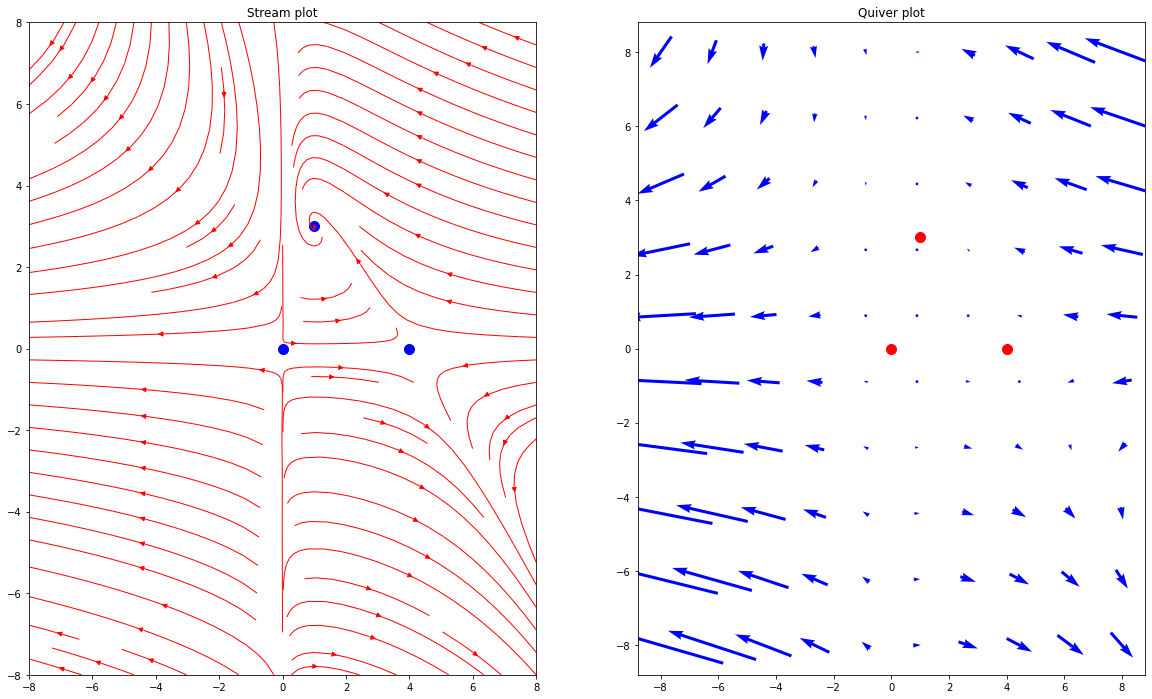

In [ ]:
w = 8
u2, u1 = np.mgrid[-w:w:100j, -w:w:100j]
aa=[0,4,1]
bb=[0,0,3]

fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(nrows=1, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.streamplot(u1,u2,8*u1-2*u1**2-2*u1*u2,u1*u2-u2,color='red',linewidth=1)
ax0.scatter(aa,bb,color='blue',s=100)
ax0.set_title('Stream plot')

w=8
u2, u1 = np.mgrid[-w:w:10j, -w:w:10j]
ax1 = fig.add_subplot(gs[0, 1])
ax1.quiver(u1,u2,8*u1-2*u1**2-2*u1*u2,u1*u2-u2,color='blue',angles='xy',pivot='middle')
ax1.scatter(aa,bb,color='red',s=100)
ax1.set_title('Quiver plot')


---

# 6. Visualization Using Public COVID19 data API

---

## 공공데이터포털 API 이용하여 데이터 긁어 오기

--- 
- 코로나 API    
[공공데이터포털](https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15043378)    
[실습 코드 참고](https://blog.naver.com/PostView.nhn?blogId=pk3152&logNo=221367298814)  
<br/>
---
### 1. 코로나19 시·도발생 현황

In [ ]:
# Url 및 Service Key 가져와서 저장
t=time.strftime('%Y%m%d', time.localtime(time.time()))
url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson'
queryParams = '?' + urlencode({ quote_plus('ServiceKey') : '서비스키', quote_plus('pageNo') : '1', quote_plus('numOfRows') : '10', quote_plus('startCreateDt') : '20200415', quote_plus('endCreateDt') : 't' })
request = Request(url + queryParams)
request.get_method = lambda: 'GET'
response_body = urlopen(request).read()

# xml -> dict -> json -> dict
rD = xmltodict.parse(response_body)   
rDJ = json.dumps(rD)
rDD = json.loads(rDJ)
w_data = rDD["response"]["body"]["items"]["item"]
df=DataFrame(w_data)
df.head()

,createDt,deathCnt,defCnt,gubun,gubunCn,gubunEn,incDec,isolClearCnt,isolIngCnt,localOccCnt,overFlowCnt,qurRate,seq,stdDay,updateDt
0,2021-07-27 09:57:20.96,9,5163,검역,隔離區,Lazaretto,45,4493,661,0,45,-,11084,2021년 07월 27일 00시,null
1,2021-07-27 09:57:20.96,1,1641,제주,济州,Jeju,17,1460,180,15,2,243.24,11083,2021년 07월 27일 00시,null
2,2021-07-27 09:57:20.96,22,6818,경남,庆南,Gyeongsangnam-do,88,5737,1059,85,3,204.12,11082,2021년 07월 27일 00시,null
3,2021-07-27 09:57:20.96,87,5345,경북,庆北,Gyeongsangbuk-do,25,5011,247,20,5,202.51,11081,2021년 07월 27일 00시,null
4,2021-07-27 09:57:20.96,17,1963,전남,全南,Jeollanam-do,15,1706,240,15,0,106.02,11080,2021년 07월 27일 00시,null


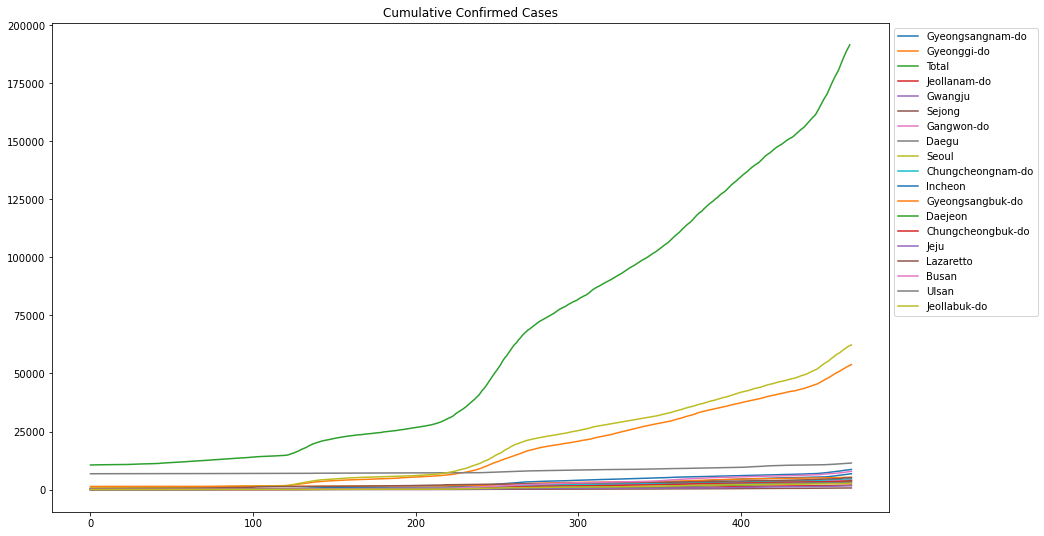

In [ ]:
#2020.04.15(등록일)~오늘 까지의 지역별 누적 확진자 그래프
plt.figure(figsize=(15,9 ))
for i in list(set((df[:]["gubunEn"]))):
    infected=list(map(int,df[df.gubunEn==i]["defCnt"][::-1]))
    plt.plot(infected,label=i)
    plt.title("Cumulative Confirmed Cases")
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

### 2. 코로나19 감염 현황

In [ ]:
# Url 및 Service Key 가져와서 저장
t=time.strftime('%Y%m%d', time.localtime(time.time()))
url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson'
queryParams = '?' + urlencode({ quote_plus('ServiceKey') : '서비스키', quote_plus('pageNo') : '1', quote_plus('numOfRows') : '10', quote_plus('startCreateDt') : '20200415', quote_plus('endCreateDt') : 't' })
request = Request(url + queryParams)
request.get_method = lambda: 'GET'
response_body = urlopen(request).read()

# xml -> dict -> json -> dict
rD = xmltodict.parse(response_body)   
rDJ = json.dumps(rD)
rDD = json.loads(rDJ)
w_data = rDD["response"]["body"]["items"]["item"]
df=DataFrame(w_data)
df.head()

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,createDt,deathCnt,decideCnt,examCnt,resutlNegCnt,seq,stateDt,stateTime,updateDt
0,1.7071723951,11528609,11219195,20823,168629,2021-07-27 09:35:45.815,2079,191531,309414,11027664,585,20210727,00:00,2021-07-27 10:08:37.339
1,1.6992241235,11472346,11191343,20724,167365,2021-07-26 09:40:26.165,2077,190166,281003,11001177,584,20210726,00:00,null
2,1.6924008113,11433347,11158586,20400,166375,2021-07-25 09:32:34.468,2073,188848,274761,10969738,583,20210725,00:00,null
3,1.6794988233,11430525,11155828,20048,165246,2021-07-24 09:38:51.376,2068,187362,274697,10968466,582,20210724,00:00,null
4,1.6717199382,11388305,11110294,19461,164206,2021-07-23 09:37:34.575,2066,185733,278011,10924561,581,20210723,00:00,null


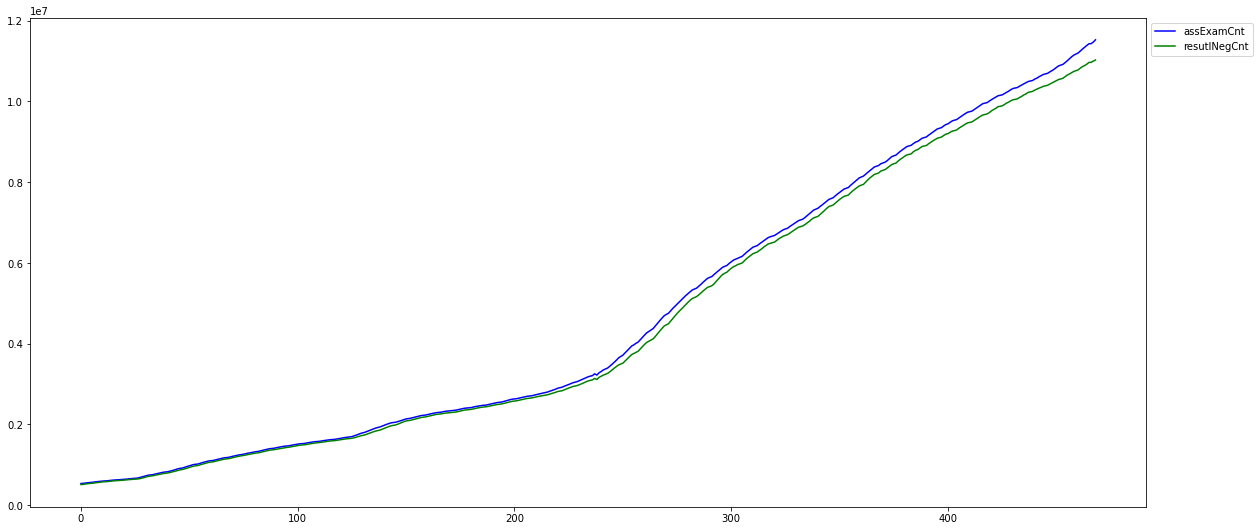

In [ ]:
#2020.04.15(등록일)~2021.07.12 까지의 코로나19 결과음성 수,누적 검사진행 수 그래프
plt.figure(figsize=(20,9 ))
exam=list(map(int,df[:]["accExamCnt"][::-1]))
res_neg=list(map(int,df[:]["resutlNegCnt"][::-1]))
exam[370]=round((exam[369]+exam[371])/2)                           #370번째 index 값 급격하게 감소
res_neg[370]=round((res_neg[369]+res_neg[371])/2)
plt.plot(exam,label="assExamCnt",color='blue')
plt.plot(res_neg,label="resutlNegCnt",color='green')
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

---

# 참고
- refactoring    
[슬라이드](https://www.slideshare.net/KennethCeyer/pycon-korea-2018-109833085)    
[유튜브](https://www.youtube.com/watch?v=MRarMhbIdcQ)  
[티스토리](https://yeomko.tistory.com/25)  
<br/>

- PEP8    
[공식문서](https://www.python.org/dev/peps/pep-0008/)  
[티스토리](https://readystory.tistory.com/22)  
<br/>

- Black    
[깃허브](https://github.com/psf/black)  
[블로그](https://www.daleseo.com/python-black/)  
<br/>

- (* vs **)  
[사이트](https://brunch.co.kr/@princox/180)
<br/>

- 마크다운    
[여백1](https://lynmp.com/en/article/cx811c9dc50y)  
[여백2](https://uwgdqo.tistory.com/29)  
[행렬](https://datastory1.blogspot.com/2017/11/r-markdown_2.html)
<br/>

# Case  
- CamelCase : Enum(열거형) / Class / NamedTuple      
[위키피디아](https://ko.wikipedia.org/wiki/%EB%82%99%ED%83%80_%EB%8C%80%EB%AC%B8%EC%9E%90)
<br/>

# 피드백  
- [0 for __ in range(100)] == [0] * 100  
- Python -> Dynamic Array -> 초기화 하지 않고 append로 늘리기  
- Solver처럼 무거운 프로그램은 한번만 돌리게 코딩하기